In [1]:
from __future__ import absolute_import, division, print_function

# Run Kernel Density Estimate on image distribution

In [192]:
import os
import json
import pandas as pd
import glob
import numpy as np
import shapefile as sf
from pyproj import Proj, transform
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import copy
from sklearn.neighbors.kde import KernelDensity
from sklearn.datasets.species_distributions import construct_grids
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.path as mplPath
import random

%matplotlib inline


In [87]:
# import dataframe
df = pd.read_pickle(os.path.join('..','..','data','dog.df'))

In [88]:
# Get CA coordinates
infile = os.path.join('..','..','data','ca_shape.csv')
ca_shape = pd.read_csv(infile)
ca_shape.head()

,longitude,latitude
0,-124.408601,40.443201
1,-124.396642,40.462119
2,-124.395598,40.464590
3,-124.388450,40.481511
4,-124.384940,40.489820


In [276]:
limit_lng = [-122.5,-122.0]
limit_lat = [37.1,37.7]
#
limit_lng = [-122.4,-122]
limit_lat = [37.4,37.7]
#
#limit_lat = []
#
if len(limit_lng) != 0 and len(limit_lat) != 0:
    yin = np.array((df['longitude'][(df['longitude'] > limit_lng[0]) & 
                                    (df['longitude'] < limit_lng[1]) & 
                                    (df['latitude'] > limit_lat[0]) & 
                                    (df['latitude'] < limit_lat[1])].tolist()))

    xin = np.array((df['latitude'][(df['longitude'] > limit_lng[0]) & 
                                   (df['longitude'] < limit_lng[1]) & 
                                   (df['latitude'] > limit_lat[0]) & 
                                   (df['latitude'] < limit_lat[1])].tolist()))
else:
    yin = np.array((df['longitude'][df['longitude'] != 0.0].tolist()))
    xin = np.array((df['latitude'][df['latitude'] != 0.0].tolist()))
#
lng_max = max(yin)
lng_min = min(yin)
lat_max = max(xin)
lat_min = min(xin)

# Create list of indices
index = list(range(len(xin)))
# shuffle list
random.shuffle(index)
# cut into chunks
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
#        
chunky = list(chunks(index,len(xin)/10))
#
xin = xin[chunky[0]]
yin = yin[chunky[0]]
# Set up the data grid for the contour plot
xgrid = np.linspace(lng_min,lng_max,100)
ygrid = np.linspace(lat_min,lat_max,100)
X, Y = np.meshgrid(xgrid, ygrid)
#
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy *= np.pi / 180.
#
Xtrain = np.vstack([xin,yin]).T
Xtrain *= np.pi / 180.  # Convert lat/long to radians

# kde = KernelDensity(bandwidth=0.0002,metric='haversine',
#                     kernel='gaussian', algorithm='ball_tree')

from sklearn import grid_search
parameters = {'bandwidth':[0.0001,0.0002,0.0003,0.0004,0.0005,0.0007,0.001,0.002,0.005]}
kde = KernelDensity()
clf = grid_search.GridSearchCV(kde, parameters)
clf.fit(Xtrain)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))
print()
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")

    

IndentationError: unexpected indent (<ipython-input-276-0a79b7d8576d>, line 9)

In [235]:
kde = KernelDensity(bandwidth=0.0003)
kde.fit(Xtrain)


KernelDensity(algorithm='auto', atol=0, bandwidth=0.0003, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

In [279]:
limit_lng = [-122.5,-122.0]
limit_lat = [37.1,37.7]
#
limit_lng = [-122.4,-122]
limit_lat = [37.4,37.7]
#
limit_lat = []
#
if len(limit_lng) != 0 and len(limit_lat) != 0:
    yin = np.array((df['longitude'][(df['longitude'] > limit_lng[0]) & 
                                    (df['longitude'] < limit_lng[1]) & 
                                    (df['latitude'] > limit_lat[0]) & 
                                    (df['latitude'] < limit_lat[1])].tolist()))

    xin = np.array((df['latitude'][(df['longitude'] > limit_lng[0]) & 
                                   (df['longitude'] < limit_lng[1]) & 
                                   (df['latitude'] > limit_lat[0]) & 
                                   (df['latitude'] < limit_lat[1])].tolist()))
else:
    yin = np.array((df['longitude'][df['longitude'] != 0.0].tolist()))
    xin = np.array((df['latitude'][df['latitude'] != 0.0].tolist()))
#
lng_max = max(yin)
lng_min = min(yin)
lat_max = max(xin)
lat_min = min(xin)

# Create list of indices
index = list(range(len(xin)))
# shuffle list
random.shuffle(index)
# cut into chunks
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
#        
chunky = list(chunks(index,len(xin)/10))

for idx,chunk in enumerate(chunky):
    xin_chunk = xin[chunk]
    yin_chunk = yin[chunk]
    # Set up the data grid for the contour plot
    xgrid = np.linspace(lng_min,lng_max,100)
    ygrid = np.linspace(lat_min,lat_max,100)
    X, Y = np.meshgrid(xgrid, ygrid)
    #
    xy = np.vstack([Y.ravel(), X.ravel()]).T
    xy *= np.pi / 180.
    #
    Xtrain = np.vstack([xin_chunk,yin_chunk]).T
    Xtrain *= np.pi / 180.  # Convert lat/long to radians
    #
    kde = KernelDensity(bandwidth=0.0003)
    kde.fit(Xtrain)
    #
    Z = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)
    #
    plt.figure(figsize=(10,10))

    # plot CA outline
    x_coords = ca_shape['longitude'].tolist()
    y_coords = ca_shape['latitude'].tolist()
    # x_coords = [x*np.pi / 180. for x in x_coords]
    # y_coords = [x*np.pi / 180. for x in y_coords]
    plt.plot(x_coords,y_coords)

    #  plot contours of the density
    levels = np.linspace(0, np.log10(Z.max()), 50)
    levels = np.linspace(0, np.sqrt(Z.max()), 50)
    # print(levels)
    # print(levels)
    # print(Z)
    plt.contourf(X, Y, np.sqrt(Z), levels=levels, cmap=plt.cm.Reds)
    if len(limit_lng) != 0 and len(limit_lat) != 0:
        plt.xlim(limit_lng[0],limit_lng[1])
        plt.ylim(limit_lat[0],limit_lat[1]) 
    else:
        plt.xlim(-123,-121.5)
        plt.ylim(36.8,38.5) 
    #
    outname = os.path.join('img/test_kde_chunk_'+str(idx)+'.png')
    plt.savefig(outname,bbox_inches='tight')

    plt.close()


## Decide which points of the grid fall into the ocean

In [198]:
# # Calculate paths number 
# x_coords = ca_shape['longitude'].tolist()
# y_coords = ca_shape['latitude'].tolist()

# bbPath = mplPath.Path(np.transpose(np.array((x_coords,y_coords))),closed=True)
# land_mask = np.vstack([Y.ravel(), X.ravel()]).T
# land_mask = (land_mask < -9999).ravel()
# print(land_mask)
# for xidx,xcoord in enumerate(xgrid):
#     for yidx,ycoord in enumerate(ygrid):
#         test = bbPath.contains_point((xcoord, ycoord))
#         if test:
#             land_mask[xidx:yidx] = True


In [199]:
# print(land_mask)

In [236]:
#Z = -9999 + np.zeros(land_mask.shape[0])
Z = np.exp(kde.score_samples(xy))
print(Z)


[  1.92236047e-01   5.37891634e-01   1.42572602e+00 ...,   5.99240927e+03
   4.02986512e+03   2.61561930e+03]


In [237]:
Z = Z.reshape(X.shape)

# Determine cluster centers

In [273]:
from sklearn.cluster import MeanShift, estimate_bandwidth

xynew = np.vstack([Y.ravel(), X.ravel(),Z.ravel()]).T
# bandwidth = estimate_bandwidth(xynew, quantile=0.1, n_samples=5000)
# print(bandwidth)
ms = MeanShift(bandwidth=12000,n_jobs=-1, bin_seeding=True)
ms.fit(xynew)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print("number of estimated clusters : %d" % n_clusters_)


number of estimated clusters : 6


# Plot results

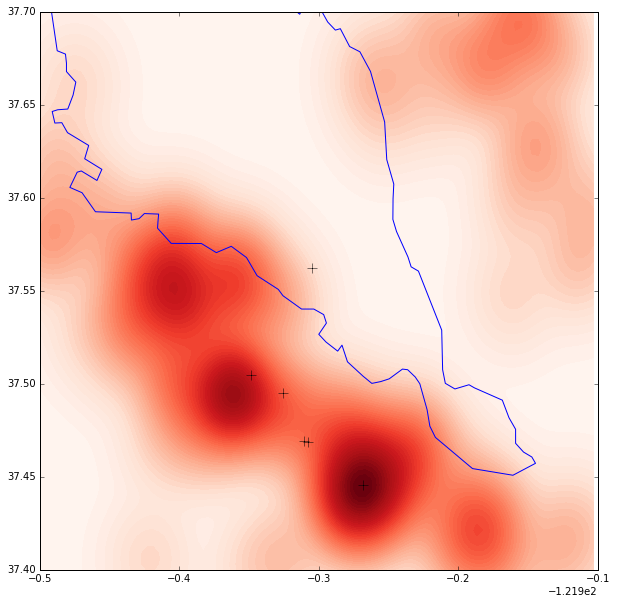

In [274]:
plt.figure(figsize=(10,10))

# plot CA outline
x_coords = ca_shape['longitude'].tolist()
y_coords = ca_shape['latitude'].tolist()
# x_coords = [x*np.pi / 180. for x in x_coords]
# y_coords = [x*np.pi / 180. for x in y_coords]
plt.plot(x_coords,y_coords)

#  plot contours of the density
levels = np.linspace(0, np.log10(Z.max()), 50)
levels = np.linspace(0, np.sqrt(Z.max()), 50)
# print(levels)
# print(levels)
# print(Z)
plt.contourf(X, Y, np.sqrt(Z), levels=levels, cmap=plt.cm.Reds)
if len(limit_lng) != 0 and len(limit_lat) != 0:
    plt.xlim(limit_lng[0],limit_lng[1])
    plt.ylim(limit_lat[0],limit_lat[1]) 
else:
    plt.xlim(-123,-121.5)
    plt.ylim(36.8,38.5) 
    
for k in range(n_clusters_):
    cluster_center = cluster_centers[k]
#     plt.plot( xynew[my_members, 1], xynew[my_members, 0],col + '.')
    plt.plot( cluster_center[1], cluster_center[0],'k+',markersize='10')
#     print(cluster_center[0], cluster_center[1])
    
plt.show()


In [275]:
# Find peaks in KDE map


In [110]:
Xtest, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=0.6)
print(Xtest)

[[ 1.49274995  0.70425011]
 [ 1.41255876  0.79018665]
 [-1.58934245 -1.89105616]
 ..., 
 [ 0.74906919 -0.53839144]
 [ 0.82532546 -1.1143188 ]
 [-1.19931257 -1.68450461]]


# Find local maxima in KDE map

In [214]:
from sklearn.cluster import MeanShift, estimate_bandwidth

xynew = np.vstack([Y.ravel(), X.ravel(),Z.ravel()]).T


bandwidth = estimate_bandwidth(xynew, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(xynew)

labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)


[[  0.00000000e+000]
 [  0.00000000e+000]
 [  0.00000000e+000]
 ..., 
 [  4.27439629e-245]
 [  7.43106755e-263]
 [  1.86311700e-281]]
number of estimated clusters : 44


In [217]:
print(cluster_centers)

[[  3.78466392e+01  -1.22419297e+02   3.90898404e+01]
 [  3.75487848e+01  -1.22194338e+02   6.21243308e+03]
 [  3.75713165e+01  -1.22227921e+02   7.37025376e+03]
 [  3.75733752e+01  -1.22236406e+02   8.18162190e+03]
 [  3.74669000e+01  -1.22108446e+02   9.83197714e+03]
 [  3.75553684e+01  -1.22218926e+02   1.13992835e+04]
 [  3.74659747e+01  -1.22157372e+02   1.20689961e+04]
 [  3.77258679e+01  -1.22328914e+02   2.28495484e+04]
 [  3.77475159e+01  -1.22273861e+02   2.21455891e+04]
 [  3.75643159e+01  -1.22164517e+02   2.46199007e+04]
 [  3.75551074e+01  -1.22130916e+02   1.72123289e+04]
 [  3.78231222e+01  -1.22256093e+02   1.56801305e+04]
 [  3.72857356e+01  -1.22050388e+02   2.07980134e+04]
 [  3.76969178e+01  -1.22169984e+02   1.44534038e+04]
 [  3.74282244e+01  -1.22131713e+02   1.89996990e+04]
 [  3.75829267e+01  -1.22117362e+02   1.81229395e+04]
 [  3.77467889e+01  -1.22324263e+02   3.22701915e+04]
 [  3.78163370e+01  -1.22390040e+02   3.60802595e+04]
 [  3.78231222e+01  -1.22354

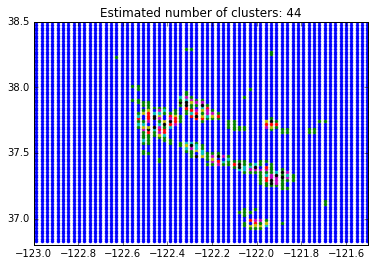

In [216]:
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()
xynew = np.vstack([Y.ravel(), X.ravel(),Z.ravel()]).T
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot( xynew[my_members, 1], xynew[my_members, 0],col + '.')
#     plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
#              markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlim(-123,-121.5)
plt.ylim(36.8,38.5) 

plt.show()



In [45]:
print(len(X))
print(len(X[0]))
print(type(X))

print(len(Z))
print(len(Z[0]))


100
100
<type 'numpy.ndarray'>
100
100


In [37]:
print(xgrid)

[-122.399 -122.395 -122.391 -122.387 -122.383 -122.379 -122.375 -122.371
 -122.367 -122.363 -122.359 -122.355 -122.351 -122.347 -122.343 -122.339
 -122.335 -122.331 -122.327 -122.323 -122.319 -122.315 -122.311 -122.307
 -122.303 -122.299 -122.295 -122.291 -122.287 -122.283 -122.279 -122.275
 -122.271 -122.267 -122.263 -122.259 -122.255 -122.251 -122.247 -122.243
 -122.239 -122.235 -122.231 -122.227 -122.223 -122.219 -122.215 -122.211
 -122.207 -122.203 -122.199 -122.195 -122.191 -122.187 -122.183 -122.179
 -122.175 -122.171 -122.167 -122.163 -122.159 -122.155 -122.151 -122.147
 -122.143 -122.139 -122.135 -122.131 -122.127 -122.123 -122.119 -122.115
 -122.111 -122.107 -122.103 -122.099 -122.095 -122.091 -122.087 -122.083
 -122.079 -122.075 -122.071 -122.067 -122.063 -122.059 -122.055 -122.051
 -122.047 -122.043 -122.039 -122.035 -122.031 -122.027 -122.023 -122.019
 -122.015 -122.011 -122.007 -122.003]


In [107]:
from sklearn.datasets.samples_generator import make_blobs

centers = [[1, 1], [-1, -1], [1, -1]]
Xnew, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=0.6)
Xnew.shape

(10000, 2)

In [59]:
print(Xnew)
print(len(X))
X.shape

[[-0.67736727 -0.93845402]
 [ 0.25300636 -0.78158718]
 [ 0.67436331  1.16600788]
 ..., 
 [ 0.62281583 -0.19684629]
 [ 1.0972231  -0.97315086]
 [-1.57045402 -0.45882662]]
100


(100, 100)

In [81]:
Z.shape

(100, 100)

In [83]:
Z_ravel = Z.ravel()


In [85]:
Z_ravel.shape

(10000,)

In [208]:
from PIL import Image
image = Image.open(os.path.join('img','test_accident_all.png'))
image = np.array(image)
print(image.shape)
flat = np.reshape(image, [-1, 3])
print(flat.shape)

(591, 598, 4)
(471224, 3)


In [209]:
xynew = np.vstack([Y.ravel(), X.ravel(),Z.ravel()]).T
print(xynew.shape)

(10000, 3)


In [210]:
ms = MeanShift(0.1, bin_seeding=True)
ms.fit(xynew)
labels=ms.labels_


In [70]:
new = X.ravel()
new.shape
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy.shape
print(xy)

[[  37.4002 -122.399 ]
 [  37.4002 -122.395 ]
 [  37.4002 -122.391 ]
 ..., 
 [  37.6992 -122.011 ]
 [  37.6992 -122.007 ]
 [  37.6992 -122.003 ]]


In [78]:
flat = np.reshape(image, [-1, 3])
print(flat)

[[255 255 255]
 [255 255 255]
 [255 255 255]
 ..., 
 [255 255 255]
 [255 255 255]
 [255 255 255]]


In [79]:
flat.shape


(471224, 3)

In [48]:
#Need to convert image into feature array based
#on rgb intensities
flat_X=np.reshape(X, [-1, 3])
print(flat_X)

ValueError: total size of new array must be unchanged

In [38]:
data = np.array([[1, 4, 3], [2, .6, 1.2], [2, 1, 1.2],
         [2, 0.5, 1.4], [5, .5, 0], [0, 0, 0],
         [1, 4, 3], [5, .5, 0], [2, .5, 1.2]])

values = data.T 


In [39]:
print(values)

[[ 1.   2.   2.   2.   5.   0.   1.   5.   2. ]
 [ 4.   0.6  1.   0.5  0.5  0.   4.   0.5  0.5]
 [ 3.   1.2  1.2  1.4  0.   0.   3.   0.   1.2]]


In [206]:
import scipy as sp

kde = sp.stats.gaussian_kde(values)
density = kde(values)
x,y,z = values

##
##clustering
##
xx = range(len(density))
m = np.array([xx, density]).T
ms = MeanShift()
ms.fit(m)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters = len(labels_unique)

print(density)
print(labels)
print("number of estimated cluster", n_clusters)


[ 0.03372205  0.0564562   0.04343546  0.04631113  0.033694    0.01660216
  0.03372205  0.033694    0.05600625]
[ 0.03372205  0.0564562   0.04343546  0.04631113  0.033694    0.01660216
  0.03372205  0.033694    0.05600625]
[5 0 0 1 1 3 2 2 4]
('number of estimated cluster', 6)
